In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("..").resolve()))

In [2]:
import geopandas as gpd
from shapely.geometry import Polygon

/home/nialov/.local/share/virtualenvs/fractopo-YImANkM_/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  warnings.warn(


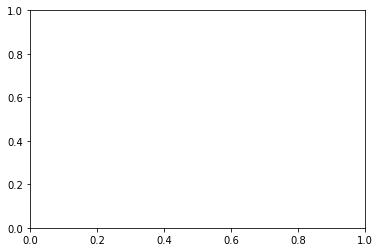

In [3]:
from fractopo import branches_and_nodes, contour_grid
from fractopo.tval import executor
from fractopo.analysis import main

In [4]:
trace_data = [
    "/mnt/f/Users/nikke/Documents/projects/Academic_projects/nordback_inkoo/dev_data/infinity_subsampled/Inkoo_Inf_lineaments_NE_circle_traces.gpkg",
    "/mnt/f/Users/nikke/Documents/projects/Academic_projects/nordback_inkoo/dev_data/infinity_subsampled/Inkoo_Inf_lineaments_SW_circle_traces.gpkg",
]
area_data = [
    "/mnt/f/Users/nikke/Documents/projects/Academic_projects/nordback_inkoo/dev_data/infinity_subsampled/Inkoo_Inf_lineaments_NE_circle_area.gpkg",
    "/mnt/f/Users/nikke/Documents/projects/Academic_projects/nordback_inkoo/dev_data/infinity_subsampled/Inkoo_Inf_lineaments_SW_circle_area.gpkg",
]

assert all([Path(filepath).exists() for filepath in trace_data+area_data])

In [5]:
traces = [gpd.read_file(data_file).set_crs("EPSG:3067", allow_override=True) for data_file in trace_data]
areas = [gpd.read_file(data_file).set_crs("EPSG:3067", allow_override=True) for data_file in area_data]

# Each trace dataset must have a target area
assert len(traces) == len(areas)

In [6]:
# Assign snap_threshold
snap_threshold = 0.001

# Generate branches and nodes for each trace dataset
branches, nodes = zip(
    *[branches_and_nodes.branches_and_nodes(trace, area, snap_threshold) for trace, area in zip(traces, areas)]
)

Loop :1


/home/nialov/nikke-projects/Pipenv_projects/fractopo/fractopo/branches_and_nodes.py:851: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:3067

  clipped_traces = gpd.clip(traces, areas)


Loop :1


/home/nialov/nikke-projects/Pipenv_projects/fractopo/fractopo/branches_and_nodes.py:851: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:3067

  clipped_traces = gpd.clip(traces, areas)


In [7]:
analysis_name = "Inkoo_inf_subsampled"
results_folder = "/mnt/f/Users/nikke/Documents/projects/Academic_projects/nordback_inkoo/dev_data/infinity_subsampled/"

In [8]:
# All datasets must have names
names = ["Inf_NE_circle", "Inf_SW_circle"]

assert len(names) == len(traces) == len(areas) == len(branches) == len(nodes)

# Each group must have defined cut offs for traces and branches
groups = ["Both_Circles"]

cut_offs_traces = [1.8]
cut_offs_branches = [1.6]

# Assign group to each dataset
datasets_grouped = ["Both_Circles", "Both_Circles"]

assert len(groups) == len(cut_offs_traces) == len(cut_offs_branches)
assert len(names) == len(datasets_grouped)

In [9]:
set_names = ["1", "2", "3"]
set_limits = [
    (0, 30),
    (30, 90),
    (90, 180),
]

assert len(set_names) == len(set_limits)

In [10]:
# Choose which analyses to perform.
choose_your_analyses = {
    "Branches": True,
    "LengthDistributions": True,
    "Azimuths": True,
    "XYI": True,
    "BranchClassification": True,
    "Topology": True,
    "Cross-cuttingAbutting": True,
    "Anisotropy": True,
    "Hexbin": True,
}

In [11]:
# Analyze trace, branch and node data
main.analyze_datasets(
    traces,
    areas,
    branches,
    nodes,
    names,
    groups,
    cut_offs_traces,
    cut_offs_branches,
    datasets_grouped,
    set_names,
    set_limits,
    analysis_name,
    results_folder,
    choose_your_analyses,
)

22442-INFO-Analysis Statistics logfile initialized.
22442-INFO-Analysis Settings and Inputs
22442-INFO------------------------------------
22442-INFO-Layer table DataFrame:
             Name         Group                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [12]:
# Whether to run contour grid sampling or not
# WARNING: Low cell_width with areally large datasets will have very long processing times.
# Be careful when running with multiscale datasets.
run_contour_sampling = False

In [13]:
if run_contour_sampling:
    # Assign cell_width
    cell_width = 2.0

    # Create sampled contour grids
    sampled_grids = [
        contour_grid.run_grid_sampling(
            trace, branch, node, cell_width
        ) for trace, branch, node in zip(traces, branches, nodes)
    ]
    # Save sampled contour grids
    [sampled_grid.to_file(f"{results_folder}plots_{analysis_name}/grid_{name}.gpkg", driver="GPKG") for sampled_grid, name in zip(sampled_grids, names)]